In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib


Found 32 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.6250 - loss: 1.7862 - val_accuracy: 0.5000 - val_loss: 1.4393 - learning_rate: 1.0000e-05
Epoch 2/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.8125 - learning_rate: 1.0000e-05
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.4688 - loss: 2.7774 - val_accuracy: 0.5000 - val_loss: 1.5022 - learning_rate: 1.0000e-05
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 1.2494 - learning_rate: 1.0000e-05
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5312 - loss: 2.6927
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.5312 - loss: 2.6927 - val_accuracy: 0.5000 - val_loss: 1.1547 - learning_rate: 1.0000e-05
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.3317 - learning_rate: 2.0000e-06
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.6562 - loss: 1.78

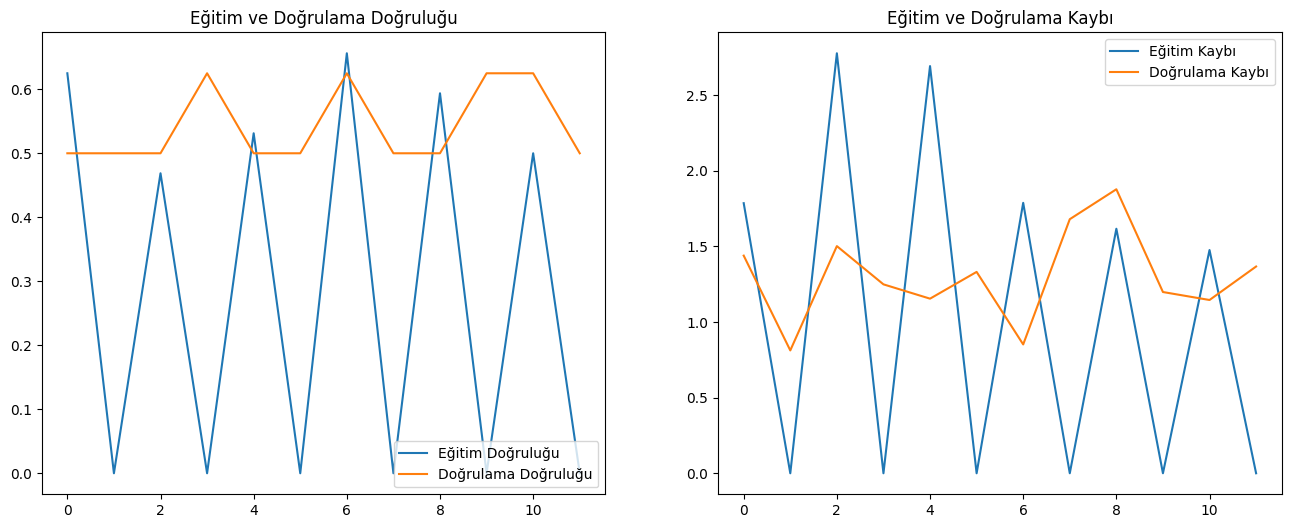

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Confusion Matrix
[[2 2]
 [1 3]]
Classification Report
              precision    recall  f1-score   support

     cleaned       0.67      0.50      0.57         4
       dirty       0.60      0.75      0.67         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/ste

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Veri yolları ve parametreler
TRAIN_DIR = '/kaggle/input/cleanedvsdirtyplates/train'
TEST_DIR = '/kaggle/input/cleanedvsdirtyplates/test'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

def create_model():
    weights_path = '/kaggle/input/weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

    base_model = VGG16(weights=weights_path , include_top=False, input_shape=(*IMG_SIZE, 3))
    
    # Son birkaç katmanı eğitilebilir yap (ince ayar)
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    for layer in base_model.layers[-4:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def load_and_preprocess_data():
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation'
    )

    return train_generator, validation_generator

def train_model(model, train_generator, validation_generator):
    lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Sınıf ağırlıklarını hesapla
    classes = train_generator.classes
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)
    class_weights = dict(enumerate(class_weights))

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stop, lr_reduce],
        class_weight=class_weights
    )
    return history

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
    plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
    plt.legend(loc='lower right')
    plt.title('Eğitim ve Doğrulama Doğruluğu')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Eğitim Kaybı')
    plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
    plt.legend(loc='upper right')
    plt.title('Eğitim ve Doğrulama Kaybı')
    plt.show()

def evaluate_model(model, validation_generator):
    # Tahminleri al
    validation_generator.reset()
    Y_pred = model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE + 1)
    y_pred = np.round(Y_pred).astype(int).flatten()

    # Gerçek etiketler
    y_true = validation_generator.classes[:len(y_pred)]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    print(cm)

    # Classification Report
    target_names = list(validation_generator.class_indices.keys())
    cr = classification_report(y_true, y_pred, target_names=target_names)
    print('Classification Report')
    print(cr)

def predict_test_data(model, test_dir):
    results = []
    for filename in os.listdir(test_dir):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(test_dir, filename)
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            prediction = model.predict(img_array)
            img_id = os.path.splitext(filename)[0]
            label = 'cleaned' if prediction[0][0] > 0.5 else 'dirty'
            results.append({'id': img_id, 'label': label})

    return results

def main():
    model = create_model()
    train_generator, validation_generator = load_and_preprocess_data()
    history = train_model(model, train_generator, validation_generator)

    # Eğitim geçmişini görselleştir
    plot_history(history)

    # Modeli değerlendir
    evaluate_model(model, validation_generator)

    # Modeli kaydet
    model.save('cleaned_dirty_plate_model.h5')

    # Test verileri üzerinde tahmin
    results = predict_test_data(model, TEST_DIR)

    # Sonuçları kaydet
    with open('submission.csv', 'w') as f:
        f.write('id,label\n')
        for result in results:
            f.write(f"{result['id']},{result['label']}\n")

    print(f"Tahminler 'submission.csv' dosyasına kaydedildi.")

if __name__ == '__main__':
    main()
